In [ ]:
#!pip install sounddevice

In [5]:
import sounddevice as sd
import numpy as np
from scipy.io import wavfile
from scipy import signal

##this records, and if we gotta make some test data we do it here. 
sample_rate=24000
duration = 5  # seconds
myrecording = sd.rec(duration * sample_rate, samplerate=sample_rate, channels=1,dtype='float64')
print("Recording Audio")
sd.wait()
print("Audio recording complete , Play Audio")



Recording Audio
Audio recording complete , Play Audio


In [6]:
##bleep for the loop
b_sample, b_data = wavfile.read('long_beep.wav')
sd.play(b_data, b_sample)

In [7]:
myrecording.shape

(120000, 1)

In [8]:
sd.play(myrecording, sample_rate)
sd.wait()

In [9]:
frequencies, times, spectrogram = signal.spectrogram(myrecording.squeeze(), sample_rate)

In [10]:
spectrogram.shape

(129, 535)

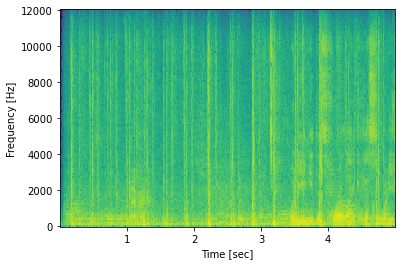

In [11]:
import matplotlib.pyplot as plt


plt.pcolormesh(times, frequencies, np.log(spectrogram)) ##log makes it prettier. for whatever reason.
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [12]:
spectrogram.shape

(129, 535)

In [13]:
!ls

API Multithreading.ipynb
Audio_file_generator.ipynb
Prediction Loop.ipynb
README.md
cuss_word_time_stamp_wisper_true.csv
dl-stfu-668ae575a084.json
dota2_chat_messages.csv
en-US.wav
en-US_3AC0C8Z3HA_0_True.wav
en-US_5G8CQA6AJ1IE9YAO4UT7.wav
en-US_6V9Y5SZ037_0_True.wav
en-US_E867GSJNPM_1_False.wav
en-US_FPAAGP4IU6_1_True.wav
en-US_PCALFJPAAU_3_True.wav
en-US_PGN9S7CKARN7LFSAOP5Q.wav
en-US_U6FL7NSHUY_1_True.wav
en-US_W1998PGPS2_4_True.wav
en-US_XP64HR8BAN_2_False.wav
kaggle_data_cleaning.ipynb
labeled_augmented.csv
long_beep.wav
mess around.ipynb
pipeline_trial.ipynb
prediction_loop_with_tall_skinny_2.ipynb
short_beep.wav
tall_skinny_2.pt
training
training_pipeline.ipynb
training_pipeline_timestamp.ipynb


In [14]:
cd training

/Users/dallin.gordon/Desktop/Class Notes/Spring 2023/DL/DL_STFU/training


In [15]:
from network_tall_skinny import TallSkinny_2

In [16]:
cd ..

/Users/dallin.gordon/Desktop/Class Notes/Spring 2023/DL/DL_STFU


In [17]:
import torch
model = TallSkinny_2()
model.load_state_dict(torch.load('tall_skinny_2.pt', map_location=torch.device('cpu')))
##100 time step 

<All keys matched successfully>

In [18]:
model = model.to('cpu')

In [19]:
model

TallSkinny_2(
  (conv1a): Conv2d(1, 4, kernel_size=(129, 1), stride=(1, 1))
  (conv1b): Conv2d(1, 4, kernel_size=(129, 3), stride=(1, 1))
  (conv1c): Conv2d(1, 4, kernel_size=(129, 5), stride=(1, 1))
  (conv1d): Conv2d(1, 4, kernel_size=(129, 10), stride=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
x = torch.ones((1,129,100))
x
model.forward(x)

In [2]:
##blocksize works if it is size sample_rate
##out
def stream_microphone(model,duration=5, sample_rate=24000, channels=1,block_duration = 100, output_window = 50, bleep_file = 'short_beep.wav'):
    """
    block duration is number of miliseconds at which it samples and runs inference
    
    output window is a hyper parameter that is the t step for the model.
    
    beep file right now is either 'long_beep.wav' or 'short_beep.wav'
    
    Stream audio from the microphone for a given duration.

    Args:
        duration (float): Duration of the audio stream in seconds (default: 10).
        sample_rate (int): Sampling rate in Hz (default: 44100).
        channels (int): Number of audio channels (default: 1).

    Returns:
        numpy.ndarray: An array of shape (samples, channels) containing the audio data.
        
    """
    b_sample, b_data = wavfile.read(bleep_file)
    
    # Calculate the number of samples based on the duration and sample rate.
    num_samples = int(duration * sample_rate)

    # Create an empty numpy array to store the audio data.
    zero_pad = int(sample_rate * block_duration * output_window / 10000)
    #model_input = np.array([], dtype=np.float32)
    model_input = np.zeros(zero_pad,dtype=np.float32)
    
    def callback(indata, frames, time, status):
        nonlocal model_input
        if status:
            print(status)
        model_input = np.append(model_input, indata.copy())  
        _, _, spectrogram = signal.spectrogram(model_input[-zero_pad:].squeeze(), sample_rate)
        inference_input = spectrogram[:,-output_window:]
        print(inference_input.shape)
        ##make inference here
        ## this if will be the result fo the inference.  
        ##print(len(model_input))
        #if len(model_input) in [40800,45600,64800,69600,74400]:
         #   sd.play(b_data, b_sample)
        
            

    with sd.InputStream( channels=1, callback=callback,
                        blocksize=int(sample_rate * block_duration / 1000),
                        samplerate=sample_rate):
        sd.sleep(int(duration * 1000))
        print("hi")
    return model_input

In [3]:
this_data = stream_microphone()

TypeError: stream_microphone() missing 1 required positional argument: 'model'

In [4]:
this_data.shape

NameError: name 'this_data' is not defined

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(this_data.squeeze(), sample_rate)

In [ ]:
plt.pcolormesh(times, frequencies, np.log(spectrogram)) ##log makes it prettier. for whatever reason.
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
sd.play(this_data, sample_rate)
sd.wait()

In [ ]:
spectrogram.shape